Example of training for the benchmark done for the Structural Damage Semantic Sementation Challenge

Carlos Fragoso
Mauricio Tumalan

In [1]:
#Install necessary libraries

!pip install lightning > /dev/null
!pip install torchinfo > /dev/null
!pip install -U segmentation-models-pytorch > /dev/null

^C
ERROR: Operation cancelled by user


In [ ]:
#Basic Imports

import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [ ]:
#Mount colab to gain access to files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data visualization

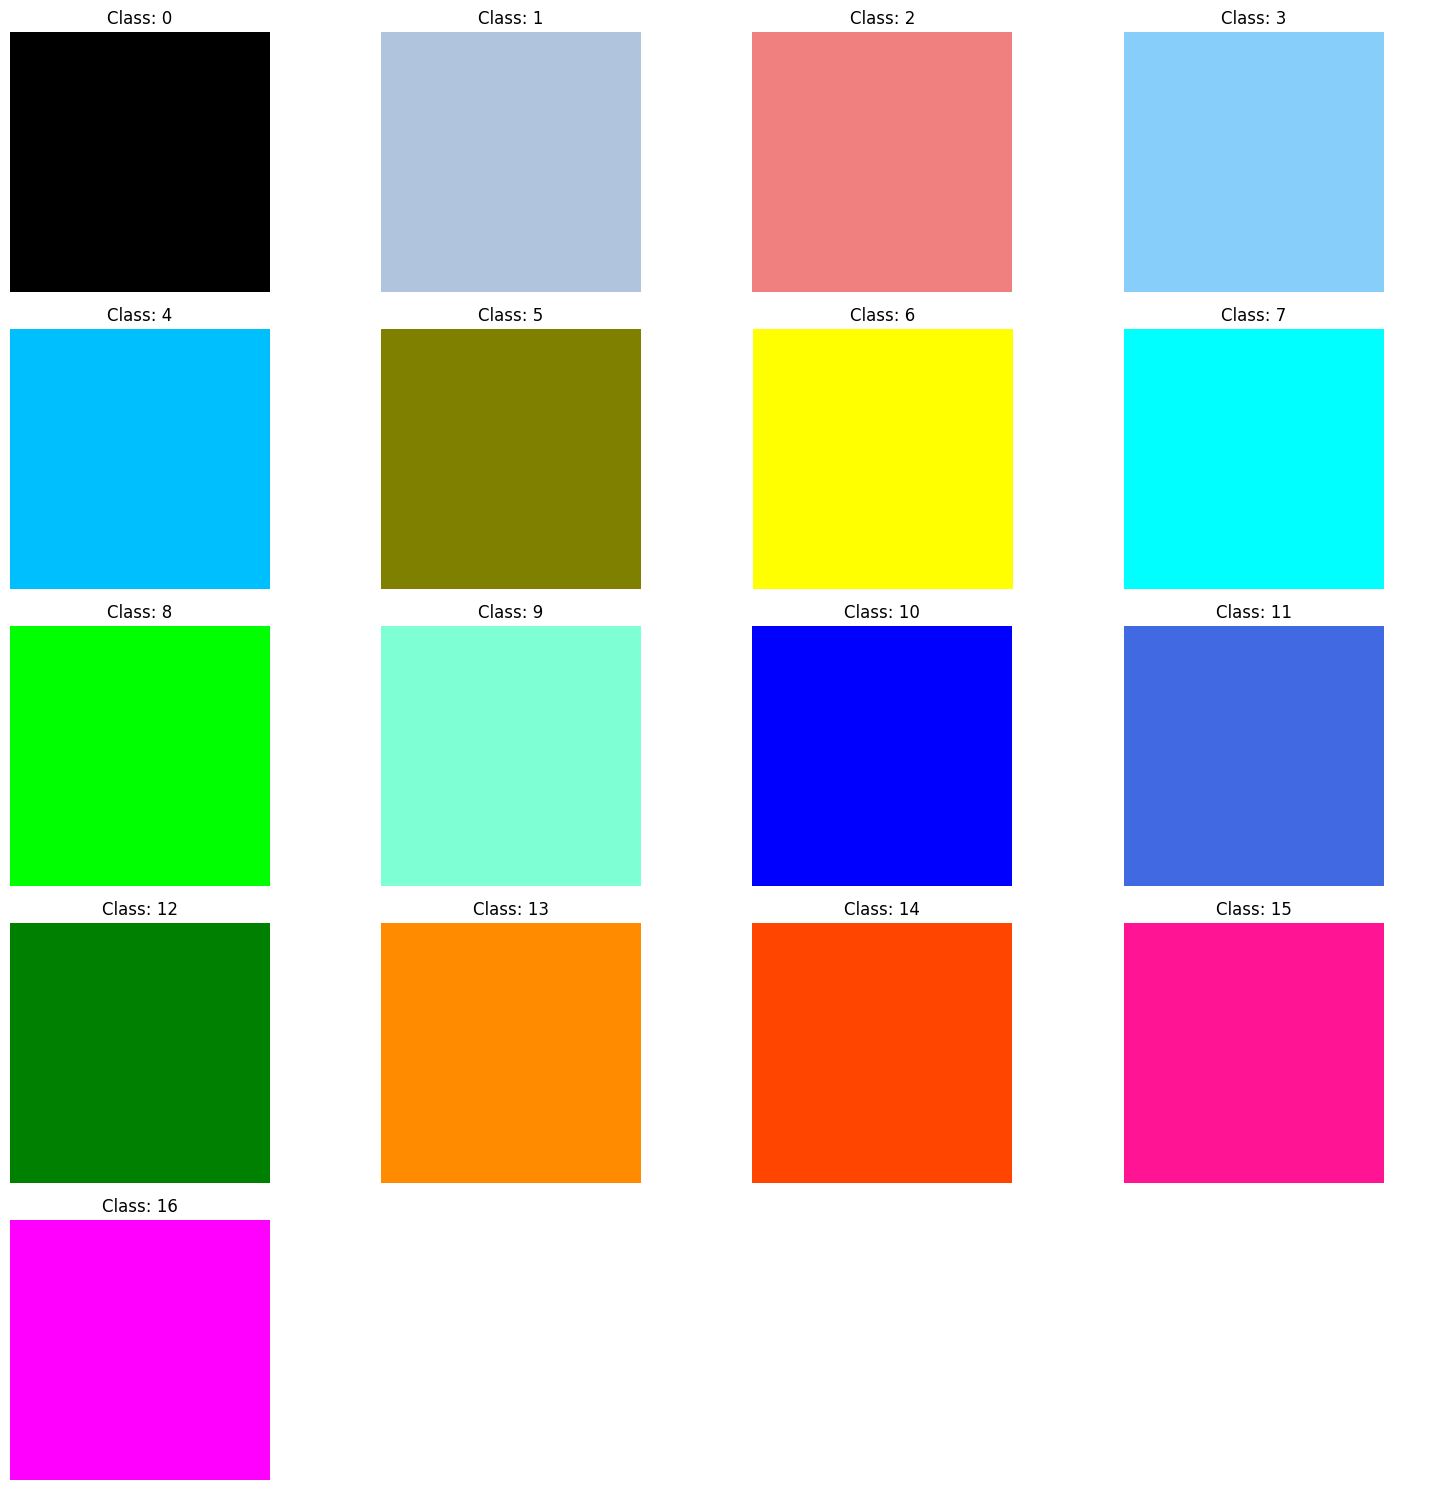

In [ ]:
#Fix path to class dictionary
classdict_path = 'path2' #Fix path!!!

def load_classdict(path=classdict_path):
    '''
    Loads class dictionary from csv file
    '''
    classdict = pd.read_csv(path)
    rgb_to_class = {
        (row['r'], row['g'], row['b']): idx
        for idx, row in classdict.iterrows()
    }
    return rgb_to_class

rgb_to_class = load_classdict(classdict_path)

num_classes = len(rgb_to_class)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols

#plot to show class dictionary
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, (rgb, cls) in enumerate(rgb_to_class.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]  # Get the current subplot

    ax.imshow(np.full((10, 10, 3), rgb, dtype=np.uint8))
    ax.set_title(f"Class: {cls}")
    ax.axis('off')  # Turn off axis ticks and labels

for i in range(num_classes, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off') # Hide subplots not used

plt.tight_layout()
plt.show()

Dataset

In [ ]:
#Defined dataset to load the images and masks to the model

class StructuralDamageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, classdict_path=None, transform=None, target_transform=None, lazy_class_mapping=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.classdict_path = classdict_path
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_transform = target_transform
        self.lazy_class_mapping = lazy_class_mapping  # Option to defer class mapping

        if len(self.images) != len(self.masks):
            raise ValueError("Number of images and masks must be equal!")

        if not lazy_class_mapping:
            # Process all masks to build class mapping
            self._build_class_mapping()
        else:
            self.unique_values = None  # Will be lazily built

    def _build_class_mapping(self):
        # Efficiently compute unique values across the dataset
        all_values = set()
        for mask_file in self.masks:
            mask_path = os.path.join(self.mask_dir, mask_file)
            mask = np.array(Image.open(mask_path).convert('L'))
            all_values.update(np.unique(mask))

        self.unique_values = sorted(all_values)  # Ensure consistent ordering
        self.value_to_class = {v: i for i, v in enumerate(self.unique_values)}
        self.num_classes = len(self.unique_values)

    def __len__(self):
        return len(self.images)

    def _lazy_class_mapping(self):
        if self.unique_values is None:
            self._build_class_mapping()

    def __getitem__(self, idx):
        try:
            # Build the class mapping lazily if needed
            if self.lazy_class_mapping:
                self._lazy_class_mapping()

            # Get paths
            img_path = os.path.join(self.image_dir, self.images[idx])
            mask_path = os.path.join(self.mask_dir, self.masks[idx])

            # Load the image and mask
            image = Image.open(img_path).convert('RGB')  # RGB image
            mask = Image.open(mask_path).convert('L')    # Grayscale mask (class indices)

            # Resize mask
            mask = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)(mask)
            mask_np = np.array(mask, dtype=np.int64)

            # Remap mask values to class indices
            mask_mapped = np.vectorize(self.value_to_class.get)(mask_np)

            # Convert to one-hot encoding
            mask_onehot = np.zeros((self.num_classes, mask_np.shape[0], mask_np.shape[1]), dtype=np.float32)
            for class_idx in range(self.num_classes):
                mask_onehot[class_idx][mask_mapped == class_idx] = 1.0

            # Convert mask to tensor
            mask_tensor = torch.tensor(mask_mapped, dtype=torch.long)

            # Apply transformations
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            if self.target_transform:
                mask_tensor = self.target_transform(mask_tensor)

            return image, mask_tensor
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise e

In [ ]:
from sklearn.model_selection import train_test_split

# Fix path for images
train_path = 'path2' #FIX PATH to the folder
image_dir = os.path.join(train_path, 'image_png')
mask_dir = os.path.join(train_path, 'mask_png')

image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Split data: 70% train, 15% validation, 15% test
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.3, random_state=42
)

valid_images, test_images, valid_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

# Check split lengths
print(f"Train: {len(train_images)}, Validation: {len(valid_images)}, Test: {len(test_images)}")

Train: 2340, Validation: 502, Test: 502


In [ ]:
# Set datasets with lens
train_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))
valid_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))
test_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, persistent_workers=True)

In [ ]:
#Batch

train_batch = next(iter(train_dataloader))

In [ ]:
images, masks = train_batch

print(images.shape)
print(masks.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
print(train_batch[0][0])
print(train_batch[1][0])

tensor([[[0.2824, 0.3176, 0.3137,  ..., 0.3922, 0.2745, 0.2039],
         [0.2627, 0.3373, 0.3412,  ..., 0.3216, 0.3255, 0.1922],
         [0.3333, 0.3098, 0.3725,  ..., 0.3451, 0.2824, 0.1608],
         ...,
         [0.1608, 0.1608, 0.1608,  ..., 0.2784, 0.2863, 0.2314],
         [0.1569, 0.1686, 0.1608,  ..., 0.3020, 0.2118, 0.1059],
         [0.1490, 0.1647, 0.1686,  ..., 0.2863, 0.1137, 0.1020]],

        [[0.2941, 0.3294, 0.3255,  ..., 0.4275, 0.3255, 0.2667],
         [0.2745, 0.3490, 0.3529,  ..., 0.3451, 0.3608, 0.2431],
         [0.3451, 0.3216, 0.3843,  ..., 0.3451, 0.2941, 0.1843],
         ...,
         [0.1608, 0.1608, 0.1608,  ..., 0.3843, 0.4039, 0.2510],
         [0.1569, 0.1686, 0.1608,  ..., 0.4157, 0.2980, 0.1294],
         [0.1490, 0.1647, 0.1686,  ..., 0.4078, 0.1765, 0.1216]],

        [[0.3294, 0.3647, 0.3608,  ..., 0.2275, 0.1569, 0.1216],
         [0.3098, 0.3843, 0.3882,  ..., 0.1686, 0.2196, 0.1294],
         [0.3804, 0.3569, 0.4196,  ..., 0.2157, 0.1922, 0.

(256, 256, 3)
(256, 256)


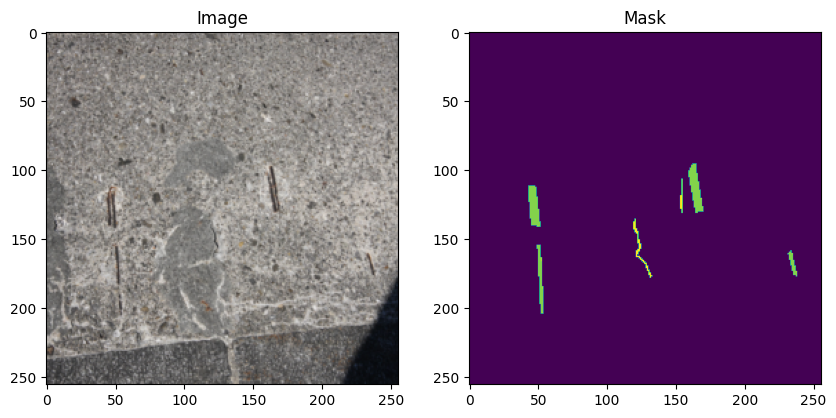

In [ ]:
image = train_batch[0][1].permute(1, 2, 0).numpy()
mask = train_batch[1][1].type(torch.int64).numpy()

print(image.shape)
print(mask.shape)

#Plot second image to see if images and masks were loaded correctly

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.show()

In [ ]:
# Load the class-to-color map
classdict = pd.read_csv(classdict_path)
color_map = {row['name']: [row['r'], row['g'], row['b']] for _, row in classdict.iterrows()}  # Map class names to RGB colors

print("Loaded color map: ", color_map)

# Create a mapping from class names to indices
class_to_index = {class_name: index for index, class_name in enumerate(color_map.keys())}

print("Class to index mapping: ", class_to_index)

Loaded color map:  {'background': [0, 0, 0], 'pequipment': [176, 196, 222], 'graffiti': [240, 128, 128], 'drainage': [135, 206, 250], 'restformwork': [0, 191, 255], 'bearing': [128, 128, 0], 'ejoint': [255, 255, 0], 'jtape': [0, 255, 255], 'cavity_rockpocket': [0, 255, 0], 'wetspot_weathering': [127, 255, 212], 'spalling_wconccor': [0, 0, 255], 'hollowareas': [65, 105, 225], 'efflorescence': [0, 128, 0], 'rust': [255, 140, 0], 'exposedrebars': [255, 69, 0], 'acrack': [255, 20, 147], 'crack': [255, 0, 255]}
Class to index mapping:  {'background': 0, 'pequipment': 1, 'graffiti': 2, 'drainage': 3, 'restformwork': 4, 'bearing': 5, 'ejoint': 6, 'jtape': 7, 'cavity_rockpocket': 8, 'wetspot_weathering': 9, 'spalling_wconccor': 10, 'hollowareas': 11, 'efflorescence': 12, 'rust': 13, 'exposedrebars': 14, 'acrack': 15, 'crack': 16}


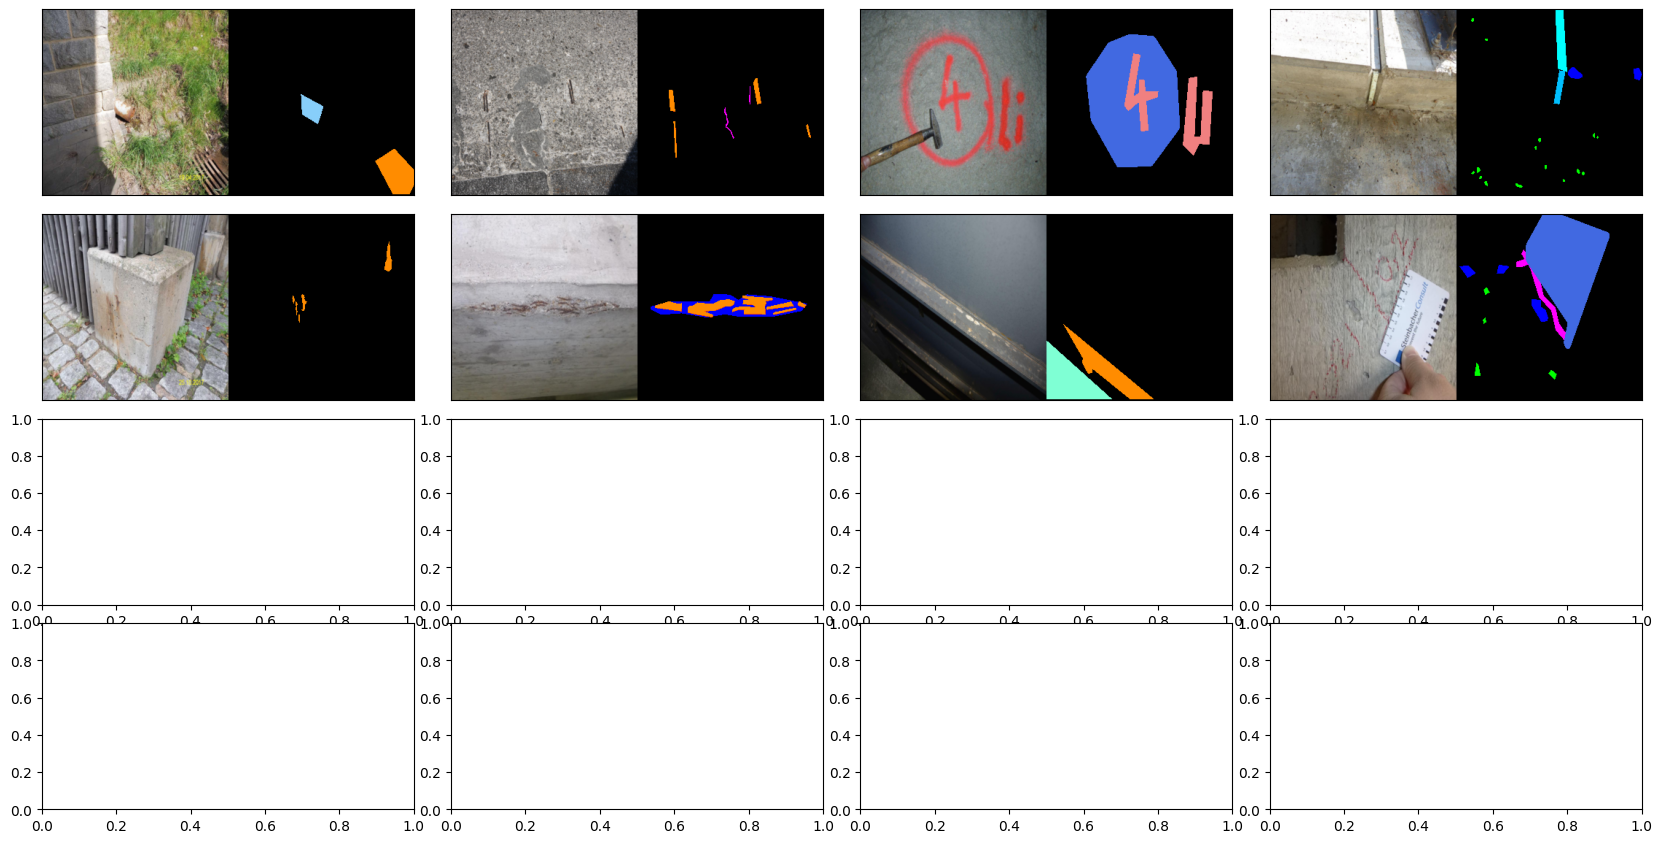

In [ ]:
# Create a 4x4 subplot figure for 16 images/masks
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
fig.tight_layout(pad=0.)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# Iterate over the first 8 images/masks in the batch
for idx in range(8):
    # Calculate the row and column index for the subplot
    row = idx // 4
    col = idx % 4

    # Extract the image and mask
    image = train_batch[0][idx].permute(1, 2, 0).numpy()  # (H, W, C)
    mask = train_batch[1][idx].numpy()  # (H, W)

    # Ensure both image and mask have the same spatial dimensions
    image = (image * 255).astype("uint8")
    mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Create a combined image-mask visualization side by side
    image_mask = np.zeros((256, 512, 3), dtype=np.uint8)  # (H, W*2, C)
    image_mask[:, :256, :] = image  # Add the image on the left
    colored_mask = np.zeros_like(image_mask[:, 256:, :])
    for class_index, color in color_map.items():
        colored_mask[mask_resized == class_to_index[class_index]] = color
    image_mask[:, 256:, :] = colored_mask # Add the colorized mask on the right


    # Display the combined image in the subplot
    ax[row, col].imshow(image_mask)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

plt.show()

### Model

In [ ]:
# Defined model structure for benchmark implementation

class StructuralDamageModel(L.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes):
        super().__init__()

        # Initialize the segmentation model
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=None)

        # Store losses
        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        # Preprocessing parameters
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # CrossEntropyLoss for multiclass segmentation
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]  # Input image: [batch_size, num_channels, height, width]
        mask = batch[1]   # Target mask: [batch_size, height, width] (class indices)

        logits_mask = self.forward(image)  # Model output: [batch_size, num_classes, height, width]

        # Compute CrossEntropyLoss directly using class indices
        loss = self.loss_fn(logits_mask, mask)

        # Metrics
        prob_mask = logits_mask.softmax(dim=1)  # Apply softmax to logits
        pred_mask = prob_mask.argmax(dim=1)  # Shape: [batch_size, height, width]
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask, mode="multiclass", num_classes=logits_mask.shape[1])

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn
        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        # Aggregate metrics
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        # Compute IoU metrics
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
#Change parameters depending on what you want to train

model = StructuralDamageModel("deeplabv3", "efficientnet-b3", in_channels=3, out_classes=17)

### Training

In [ ]:
# Early stop is a callback that is used to stop the training process when the validation loss does not improve. In this case, we are
# using the EarlyStopping callback to stop the training process when the validation loss does not improve for 3 epochs.
earlystop_callback = EarlyStopping(
    monitor="valid_loss",  # Metric to monitor
    patience=3,            # Number of epochs to wait for improvement
    verbose=True,          # Print logs about early stopping
    mode="min"             # Minimize the monitored metric
)

# Define a logger to save logs
logger = CSVLogger(save_dir="logs/", name="struct-model")

# Define the Trainer with the callbacks and logger
trainer = L.Trainer(
    max_epochs=10,               # Maximum number of epochs
    logger=logger,               # Save logs in a CSV file
    callbacks=[earlystop_callback],  # Add EarlyStopping to callbacks
    accelerator="gpu",           # Use GPU if available
    devices=1,                   # Number of GPUs to use (set to 1 here)
    accumulate_grad_batches=4    # Accumulate gradients over 2 batches
)

# Start training
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved. New best score: 1.048
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved. New best score: 1.048


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.964
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.926
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.926


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.898
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.877
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.877


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.860
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.846
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.846


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.833
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.822
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.812
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.812
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_loss': 0.8036977052688599, 'valid_per_image_iou': 0.665111243724823, 'valid_dataset_iou': 0.5780494809150696}]


In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.7192283272743225, 'test_per_image_iou': 0.665111243724823, 'test_dataset_iou': 0.5780494809150696}]


,step,test_dataset_iou,test_loss,test_per_image_iou,train_dataset_iou,train_loss,train_per_image_iou,valid_dataset_iou,valid_loss,valid_per_image_iou
epoch,,,,,,,,,,
0,104.0,NaN,NaN,NaN,0.578049,1.687992,0.665111,0.578049,1.047601,0.665111
1,209.0,NaN,NaN,NaN,0.578049,1.330572,0.665111,0.578049,0.963551,0.665111
2,314.0,NaN,NaN,NaN,0.578049,1.175788,0.665111,0.578049,0.926237,0.665111
3,419.0,NaN,NaN,NaN,0.578049,1.088941,0.665111,0.578049,0.897820,0.665111
4,524.0,NaN,NaN,NaN,0.578049,1.032532,0.665111,0.578049,0.877243,0.665111
5,629.0,NaN,NaN,NaN,0.578049,0.992660,0.665111,0.578049,0.860191,0.665111
6,734.0,NaN,NaN,NaN,0.578049,0.962425,0.665111,0.578049,0.845665,0.665111
7,839.0,NaN,NaN,NaN,0.578049,0.937672,0.665111,0.578049,0.833241,0.665111
8,944.0,NaN,NaN,NaN,0.584088,0.916985,0.670329,0.584088,0.822459,0.670329


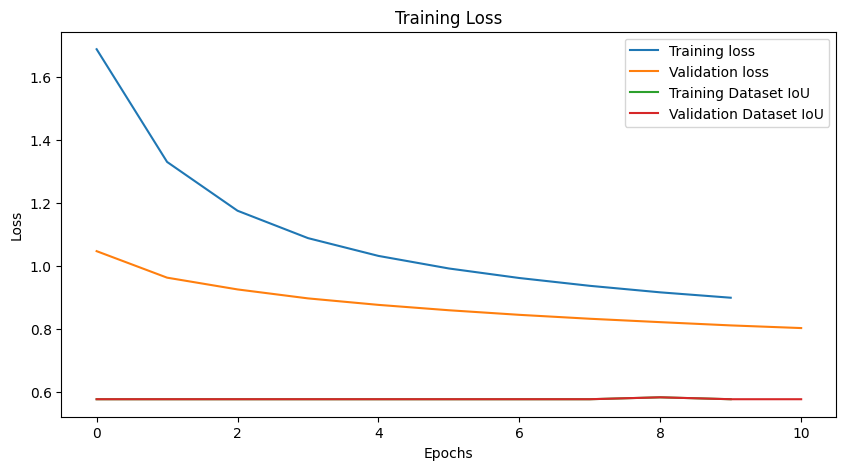

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [ ]:
#testing batch image prediction

batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    class_labels = pr_mask.argmax(dim=0).cpu().numpy()

    # Display the class labels directly
    plt.imshow(class_labels)
    plt.title("Prediction")
    plt.axis("off")

    plt.show()